In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import beamforming
import micro_motion_amp
import cardiac_focusing

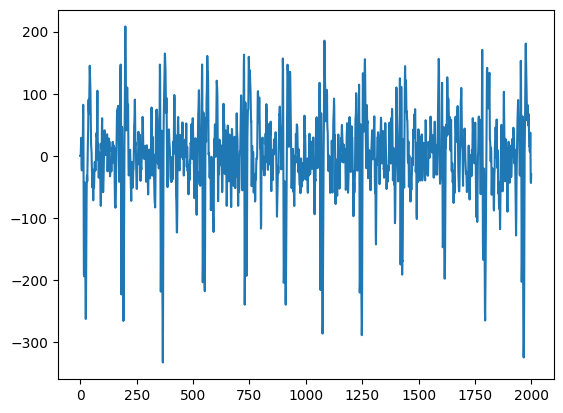

In [47]:
data = pickle.load(open('matched_1723609564.3745.pkl', 'rb'))
# matched.pkl is generated using voxel 4,7,10
h = np.angle(data[0][3,5,9])
h = np.unwrap(h)
mmwave_data = micro_motion_amp.second_dev(h, 1/200)
plt.plot(mmwave_data[0:2000])

In [118]:
print(data[0][3,0,0])

[-43857.39 +160806.56j -48444.848+159738.81j -52381.875+158201.95j ...
  95514.08 -161101.22j  96883.51 -160964.47j  96971.64 -159560.28j]


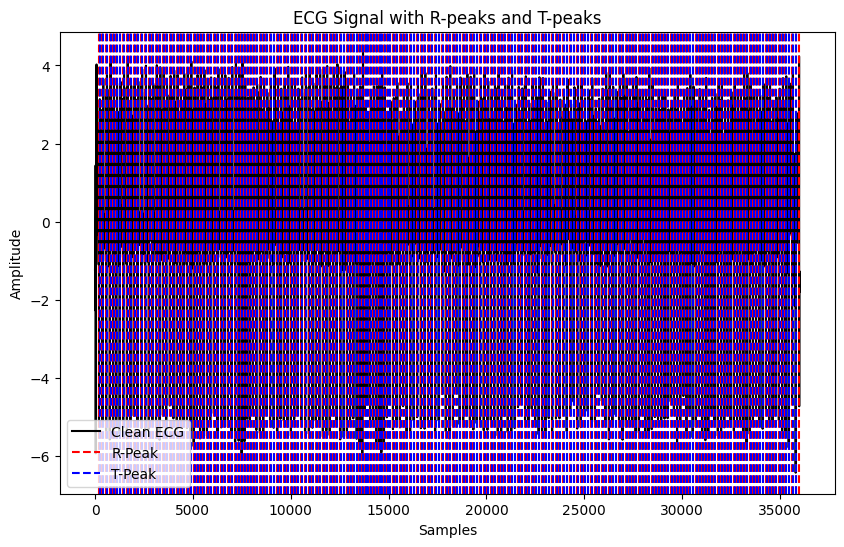

In [70]:
ecg_signal = data[1]
sampling_rate = 200
ecg_clean = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate)

# Detect R-peaks
_, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=sampling_rate)

# Initialize list to store T-peaks
tpeaks = []

# Define the search window for T-peaks (typically between 0.15 to 0.35 seconds after the R-peak)
t_window_start = int(0.15 * sampling_rate)
t_window_end = int(0.35 * sampling_rate)

# Search for T-peaks after each R-peak
for rpeak in rpeaks['ECG_R_Peaks']:
    # Define the search window for the T-peak after the R-peak
    search_window = ecg_clean[rpeak + t_window_start : rpeak + t_window_end]
    
    # Find the maximum within the search window
    if len(search_window) > 0:
        tpeak = np.argmax(search_window) + rpeak + t_window_start  # Adjust the index to the full signal
        tpeaks.append(tpeak)

# Plot R-peaks and T-peaks
plt.figure(figsize=(10, 6))
plt.plot(ecg_clean, label="Clean ECG", color='black')

# Mark R-peaks with red vertical lines
for rpeak in rpeaks['ECG_R_Peaks']:
    plt.axvline(x=rpeak, color='red', linestyle='--', label='R-Peak' if rpeak == rpeaks['ECG_R_Peaks'][0] else "")

# Mark T-peaks with blue vertical lines
for tpeak in tpeaks:
    plt.axvline(x=tpeak, color='blue', linestyle='--', label='T-Peak' if tpeak == tpeaks[0] else "")

plt.legend()
plt.title("ECG Signal with R-peaks and T-peaks")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

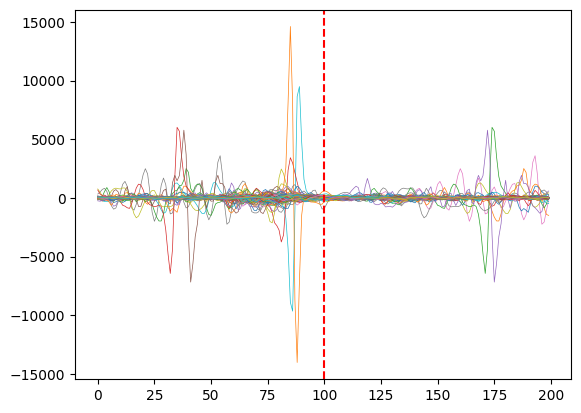

In [11]:
for rpeak in rpeaks['ECG_R_Peaks']:
    plt.plot(mmwave_data[rpeak-100:rpeak+100], linewidth=0.5)

plt.axvline(100, color='r', linestyle='--')

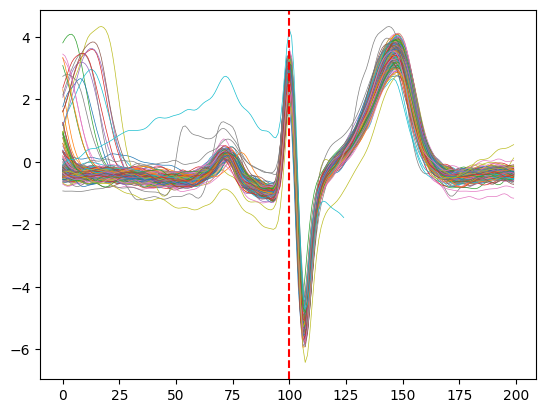

In [12]:
for rpeak in rpeaks['ECG_R_Peaks']:
    plt.plot(ecg_clean[rpeak-100:rpeak+100], linewidth=0.5)

plt.axvline(100, color='r', linestyle='--')

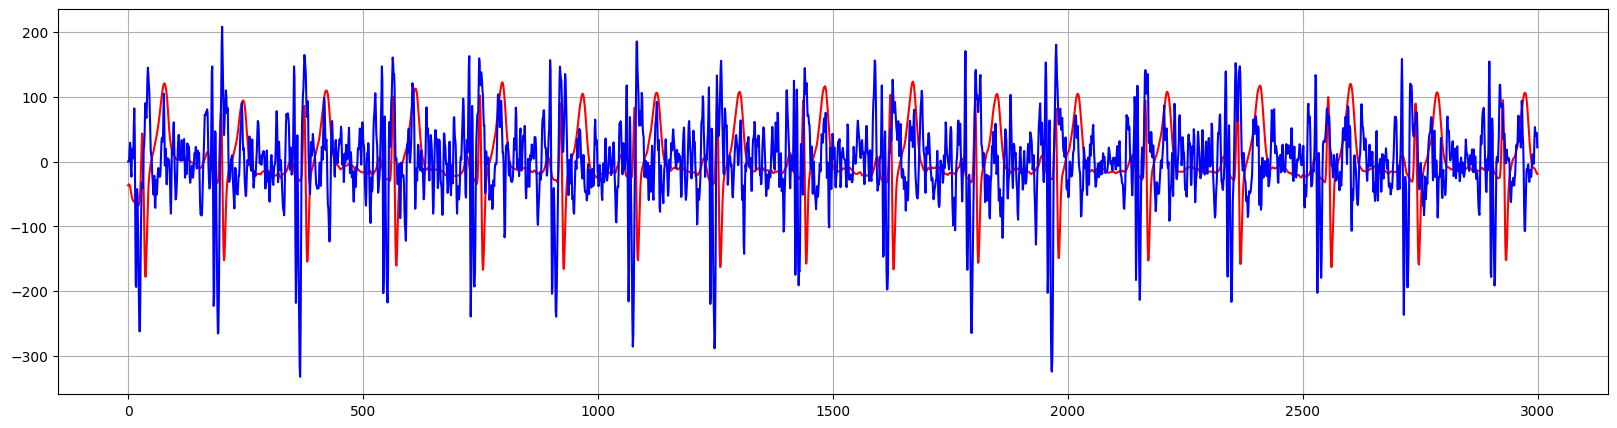

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(ecg_clean[0:3000]*30, color='r')
plt.plot(mmwave_data[0:3000], color='b')
plt.grid()

In [2]:
# Retrive the original beamforming signal
d_1 = pickle.load(open("../clean_code/1723609564.3745.pkl", "rb"))
info = d_1[1]
d_1 = np.array(d_1[0]) 
print(d_1)

[[[[ 1.01006458e+03+4.92918262e+03j  1.23135840e+03+6.14285449e+03j
     1.89141748e+03+5.55018457e+03j ... -5.36794092e+03+5.57596680e+03j
    -5.55925146e+03+6.07329688e+03j -4.78677441e+03+5.67014600e+03j]
   [-1.42298887e+04-1.04685293e+04j -1.51277373e+04-9.76444922e+03j
    -1.40531016e+04-9.40449414e+03j ... -8.87485938e+03-6.17140088e+03j
    -9.09254980e+03-5.62404736e+03j -8.25127051e+03-6.39409229e+03j]
   [-2.77068164e+03+1.73107227e+04j -3.20485254e+03+1.69879727e+04j
    -3.87760303e+03+1.68171738e+04j ...  1.21411709e+04-1.42740149e+03j
     1.13481299e+04-2.07547534e+03j  1.28248389e+04-1.59301733e+03j]
   ...
   [ 5.88432275e+03-1.88111113e+04j  6.20210596e+03-1.85596934e+04j
     7.04885059e+03-1.83857852e+04j ... -1.20152891e+04+1.97139844e+03j
    -1.12313135e+04+2.56034937e+03j -1.27173623e+04+2.13646973e+03j]
   [ 2.09960293e+04-4.11805273e+03j  2.11463359e+04-4.22656104e+03j
     2.07926758e+04-4.60363379e+03j ...  1.07739512e+04-3.84928589e+03j
     1.05618770e+

In [29]:
from scipy.signal import resample
import numpy as np
from scipy.signal import resample
from tslearn.metrics import dtw as tsl_dtw
from multiprocessing import Pool, shared_memory
import micro_motion_amp

def linear_time_warp(signal, target_length):
    """
    Linearly time warps the signal to the target length.
    """
    warped_signal = resample(signal, target_length)
    return warped_signal

def pattern_matching(signal):
    hmax = 200
    hmin = 100
    # TRY STEP = 2hmax
    #T_c = [signal[i:i+hmax] for i in range(0, len(signal), hmax)] # Generate corse template for cardiac motion window with length hmax
    T_c = T_c = [signal[0:hmax]]
    step = 2 # Define how the point step we calculates dtw

    # Step 1: Calculating the dtw scores for all segments
    dtw_index_scores = [] # Store each dtw value in terms of [index,score]

    index = 0 # Index of the starting point in the segment
    while index + hmax < len(signal): # Traverse all suitable starting index in the whole signal
        dtw = np.sum([tsl_dtw(signal[index:index+hmax], template) for template in T_c])
        dtw_index_scores.append([index,dtw])
        index += step
    dtw_index_scores = np.array(dtw_index_scores)

    # Step 2: Find the index of segment corresponds to the smallest dtw
    i = 0 # Starting index
    indexes = [] # Index list of segment with smallest dtw (overlapped)
    while True:
        search_range = dtw_index_scores[(dtw_index_scores[:,0] >= i + hmin) & (dtw_index_scores[:,0] <= i + hmax)]
        if search_range.shape[0] == 0:
            break

        i = search_range[np.argmin(search_range[:,1]), 0]
        indexes.append(i)
    
    # Step 3: Reform the non-overlapping segmentation
    S_dagger = [] # Non-overalpped signal segment
    T_dagger = np.zeros(hmax) # Final template

    for i in range(len(indexes)-1):
        S_dagger_i = signal[int(indexes[i]):int(indexes[i+1])]
        S_dagger.append(S_dagger_i) # Non-overlapped signal with various length
        T_dagger += linear_time_warp(S_dagger_i, hmax) # Linear time wrap signal length to hmax

    # Step 4: Update the template
    T_dagger /= len(indexes) # Average of non-overlapped signal uses as final template
    # print(T_dagger)
    # print(len(T_dagger))
    # return T_dagger

    # Step 5: Calculate the dtw score
    # Calculate the average score of the signal
    pattern_score = 0
    for dtws in S_dagger: # Traverse all segment, calculate the average dtw score
        pattern_score += tsl_dtw(dtws, T_dagger)
    pattern_score /= len(S_dagger)

    return T_dagger, pattern_score, indexes

def calculate_power(signal):
    """
    Calculate the power of a signal as the mean of the squared amplitudes.
    """
    return np.mean(np.square(signal))

def focusing(signal, thr=120):
    points = []
    selected_voxels = []
    voxel_powers = []
    
    for x in range(9):
        for y in range(9):
            for z in range(17):
                # Apply second derivative to the unwrapped phase signal
                seq = micro_motion_amp.second_dev(np.unwrap(np.angle(signal[x,y,z,:])),1/200)
                
                # Perform pattern matching
                T_dagger, pattern_score, indexes = pattern_matching(seq)
                print(f'x: {x}, y: {y}, z: {z}, score: {pattern_score}')

                points.append([x, y, z, pattern_score])  # Store voxel location and DTW score
                selected_voxels.append(signal[x, y, z, :])  # Store the corresponding signal
                
                # Calculate the power of the signal
                voxel_powers.append(calculate_power(signal[x, y, z, :]))
                
                # Select the voxel if the pattern score is below the threshold
                # if pattern_score <= thr:
                #     points.append([x, y, z, pattern_score])  # Store voxel location and DTW score
                #     selected_voxels.append(signal[x, y, z, :])  # Store the corresponding signal
                    
                #     # Calculate the power of the signal
                #     voxel_powers.append(calculate_power(signal[x, y, z, :]))

    # Select points based on number instead of scores ----------------------------------------------
    # Sort the voxels according to dtw score in ascending order
    sorted_points = sorted(zip(points, selected_voxels, voxel_powers), key=lambda x: x[0][3])
    # Select the first 120 points
    selected_points = sorted_points[:thr]

    points = [p[0] for p in selected_points] # [x,y,z,score]
    selected_voxels = [p[1] for p in selected_points] # [original voxel point]
    voxel_powers = [p[2] for p in selected_points] # power list
    
    # Convert the selected voxel positions and power into voxel_info format
    voxel_info = [(x, y, z, power) for (x, y, z, _), power in zip(points, voxel_powers)]
    
    # Convert selected_voxels into a 2D array for voxel_signals
    voxel_signals = np.array(selected_voxels)
    
    print(f'Selected Points: {points}')
    print(f'Number of selected voxels: {len(selected_voxels)}')
    
    return voxel_info, voxel_signals

# Example usage
voxel_info, voxel_signals = focusing(data[0])

x: 0, y: 0, z: 0, score: 11947.445939353174
x: 0, y: 0, z: 1, score: 11762.922612710916
x: 0, y: 0, z: 2, score: 8314.636721303656
x: 0, y: 0, z: 3, score: 3197.054376055322
x: 0, y: 0, z: 4, score: 3927.190770694404
x: 0, y: 0, z: 5, score: 5192.514716116095
x: 0, y: 0, z: 6, score: 3037.9280157325734
x: 0, y: 0, z: 7, score: 4260.744412972089
x: 0, y: 0, z: 8, score: 2790.315998679364
x: 0, y: 0, z: 9, score: 1779.474784272694
x: 0, y: 0, z: 10, score: 1674.4817840419812
x: 0, y: 0, z: 11, score: 2486.990647411687
x: 0, y: 0, z: 12, score: 4350.1635438712065
x: 0, y: 0, z: 13, score: 6676.011802573098
x: 0, y: 0, z: 14, score: 8000.742337194404
x: 0, y: 0, z: 15, score: 7180.093983984186
x: 0, y: 0, z: 16, score: 12346.538803317571
x: 0, y: 1, z: 0, score: 11078.12372445003
x: 0, y: 1, z: 1, score: 10113.494019678397
x: 0, y: 1, z: 2, score: 10185.11793910029
x: 0, y: 1, z: 3, score: 5324.152042529786
x: 0, y: 1, z: 4, score: 4042.613008735487
x: 0, y: 1, z: 5, score: 5347.6831729276

In [31]:
'''
Getting data from log output
'''
def parse_xyz_score(data): 
    result = [] 
    for line in data.split('\n'): 
        if line.strip(): # Check if line is not empty 
            parts = line.split(',') 
            x = int(parts[0].split(':')[1]) 
            y = int(parts[1].split(':')[1]) 
            z = int(parts[2].split(':')[1]) 
            score = float(parts[3].split(':')[1]) 
            result.append([x, y, z, score]) 
    return result

In [32]:
with open('1723609564.3745_focusing_results.pkl', 'wb') as f:
    pickle.dump((voxel_info, voxel_signals), f)

In [3]:
with open('1723609564.3745_focusing_results.pkl', 'rb') as f:
    voxel_info, voxel_signals = pickle.load(f)

In [119]:
print(voxel_info[0])
print(voxel_signals[0])


(3, 0, 0, (-588842240+937733700j))
[-43857.39 +160806.56j -48444.848+159738.81j -52381.875+158201.95j ...
  95514.08 -161101.22j  96883.51 -160964.47j  96971.64 -159560.28j]


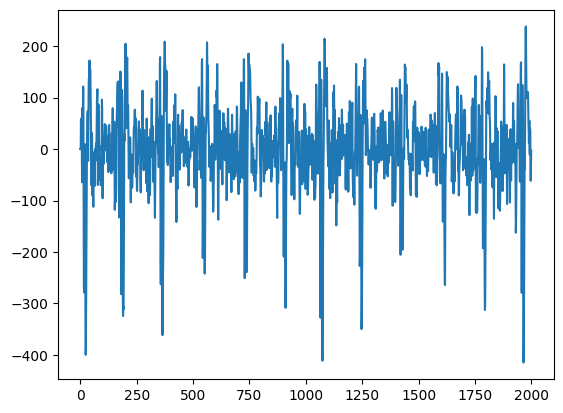

In [120]:
h = np.angle(voxel_signals[0])
h = np.unwrap(h)
mmwave_data = micro_motion_amp.second_dev(h, 1/200)
plt.plot(mmwave_data[0:2000])

(120, 3)


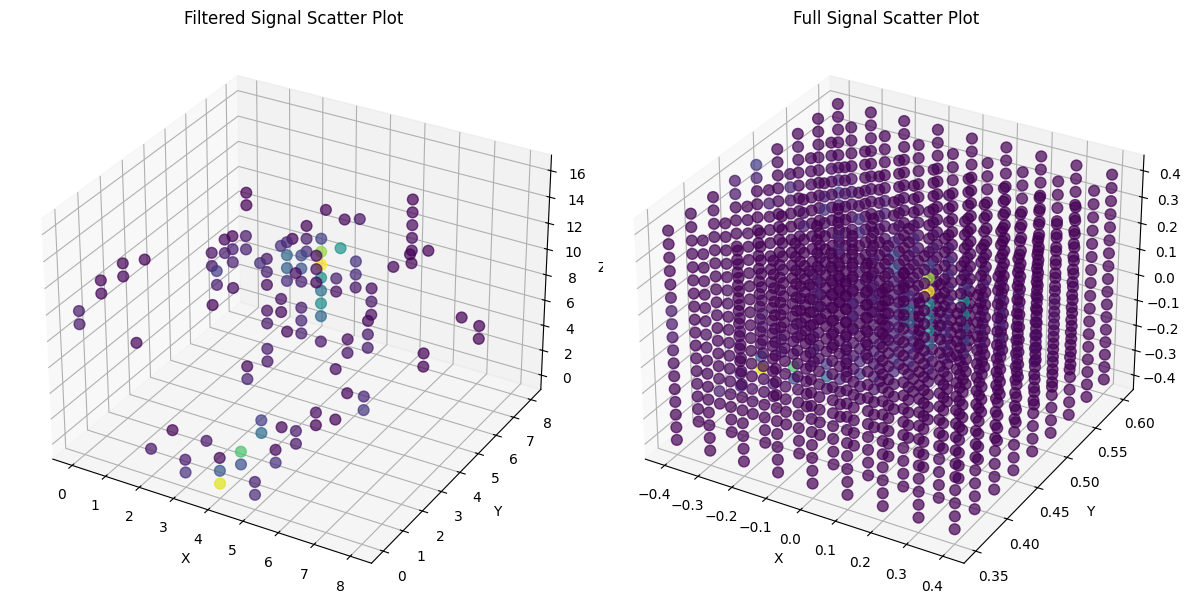

In [4]:
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_scatter_filter(signal_array, voxel_info, info):
    """
    Plot the scatter plots of selected and full voxel signals.
    
    Parameters:
    - signal_array: The original 4D signal data (e.g., d_1).
    - voxel_info: List of selected voxel positions [(x, y, z, power)].
    - info: Dictionary with voxel dimensions and ranges.
    
    Returns:
    - filtered_power: Power of the selected filtered signals.
    - original_power: Power of the full signal grid.
    """
    
    sum_power = np.zeros(info['voxel_grid_dimensions'])

    # Calculate the power for each voxel in the full signal grid
    for x in range(info['voxel_grid_dimensions'][0]):
        for y in range(info['voxel_grid_dimensions'][1]):
            for z in range(info['voxel_grid_dimensions'][2]):
                for i in range(info['clip']):
                    sum_power[x, y, z] += np.abs(signal_array[x, y, z, i])**2

    # Calculate average power per voxel across time
    power = sum_power / info['clip']

    # Extract filtered voxel coordinates from voxel_info
    filtered_coords = np.array([[x, y, z] for x, y, z, _ in voxel_info])
    print(filtered_coords.shape)

    # Prepare the figure and two separate subplots with 3D axes
    fig = plt.figure(figsize=(12, 6))

    # First scatter plot: using filtered coordinates and filtered power
    ax1 = fig.add_subplot(121, projection='3d')  # 1st subplot
    filtered_power = []
    for coord in filtered_coords:
        filtered_power.append(power[int(coord[0]), int(coord[1]), int(coord[2])])
    filtered_power = np.array(filtered_power)

    ax1.scatter(filtered_coords[:, 0], filtered_coords[:, 1], filtered_coords[:, 2], 
                c=filtered_power, s=60, alpha=0.7, marker='o')
    ax1.set_title('Filtered Signal Scatter Plot')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Second scatter plot: using all voxel grid points and their power values
    ax2 = fig.add_subplot(122, projection='3d')  # 2nd subplot
    X = np.linspace(info['voxel_range']['x'][0], info['voxel_range']['x'][1], info['voxel_grid_dimensions'][0])
    Y = np.linspace(info['voxel_range']['y'][0], info['voxel_range']['y'][1], info['voxel_grid_dimensions'][1])
    Z = np.linspace(info['voxel_range']['z'][0], info['voxel_range']['z'][1], info['voxel_grid_dimensions'][2])
    X, Y, Z = np.meshgrid(X, Y, Z)

    ax2.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=power.flatten(), s=60, alpha=0.7, marker='o')
    ax2.set_title('Full Signal Scatter Plot')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Save the power array to a .mat file
    sio.savemat('power.mat', {'power': power})
    sio.savemat('power_filter.mat', {'filtered_power': filtered_power})
    return filtered_power, power

# Example usage:
# Assuming `focusing` has been run and returned `voxel_info` and `voxel_signals`
# signal_array should be your original 4D signal data
# info should contain voxel dimensions, ranges, and clip information

# Example:
# filtered_power, original_power = plot_scatter_filter(d_1, voxel_info, info)


filtered_power, original_power = plot_scatter_filter(d_1, voxel_info, info)

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def cluster_signals(voxel_info, filtered_power, voxel_signals, N_clusters=50, rho_s=0.3, rho_p=0.7, max_iter=100, tol=1e-4):
    """
    Perform clustering based on position, reflected energy, and time-domain signal correlation.
    Plot original signal positions (including excluded signals) and clustered positions.
    
    Parameters:
    - voxel_info: List of voxel positions and signal power in the format [(x, y, z, p), ...].
    - filter_power: power for each filter voxel.
    - voxel_signals: List of corresponding signals in the format [[sequence]].
    - N_clusters: Number of clusters.
    - rho_s: Scaling factor for signal motion difference.
    - rho_p: Scaling factor for positional difference.
    - max_iter: Maximum number of iterations for the EM algorithm.
    - tol: Tolerance for convergence.

    Returns:
    - merged_signals: Array of merged signals for each cluster.
    - centroids: Final centroids for signal motion.
    - position_centroids: Final centroids for position.
    - clustered_signals: List of signals for each cluster, where each entry contains a dictionary 
                        with 'positions' and 'signals' for that cluster.
    """
    
    # Extract signal positions (x, y, z) and power (p) from voxel_info and filtered_power
    positions = np.array([[x, y, z] for (x, y, z, p) in voxel_info])
    powers = np.array(filtered_power)
    
    num_voxels, num_frames = voxel_signals.shape
    
    # Pre-allocate array for processed signals (assuming processed signals have the same length as original)
    processed_signals = np.zeros((num_voxels, num_frames))
    
    dt = 1 / 200  # Time step for second_dev function
    
    for i, signal in enumerate(voxel_signals):
        # Step 1: Compute the phase angle of the signal
        phase_angle = np.angle(signal)
        
        # Step 2: Unwrap the phase
        unwrapped_phase = np.unwrap(phase_angle)
        
        # Step 3: Apply the second derivative operation
        processed_signal = micro_motion_amp.second_dev(unwrapped_phase, dt)
        
        # Store the processed signal in the numpy array
        processed_signals[i, :len(processed_signal)] = processed_signal
    
    voxel_signals = processed_signals
    
    # Initialize centroids for both signal and position
    centroids = np.random.randn(N_clusters, num_frames)  # Randomly initialize signal centroids
    position_centroids = np.random.randn(N_clusters, 3)  # Randomly initialize position centroids
    
    # Initialize cluster assignments
    cluster_assignments = -1 * np.ones(num_voxels, dtype=int)  # -1 means not assigned to any cluster
    
    for iteration in range(max_iter):
        # E-Step: Assign voxels to clusters based on the objective function J
        for i in range(num_voxels):
            min_distance = np.inf
            for k in range(N_clusters):
                # Compute signal motion difference
                signal_diff = np.linalg.norm(voxel_signals[i] - centroids[k]) ** 2
                
                # Compute position difference
                position_diff = np.linalg.norm(positions[i] - position_centroids[k]) ** 2
                
                # Objective function J
                J = rho_s * signal_diff + rho_p * position_diff
                
                # Check if this is the closest cluster
                if J < min_distance:
                    min_distance = J
                    cluster_assignments[i] = k  # Assign voxel to this cluster
        
        # M-Step: Update centroids based on the current cluster assignments
        new_centroids = np.zeros_like(centroids)
        new_position_centroids = np.zeros_like(position_centroids)
        for k in range(N_clusters):
            cluster_indices = np.where(cluster_assignments == k)[0]
            if len(cluster_indices) > 0:
                # Update signal centroids based on the weighted sum of signals
                new_centroids[k] = np.sum(voxel_signals[cluster_indices] * powers[cluster_indices, None], axis=0) / np.sum(powers[cluster_indices])
                
                # Update position centroids based on the weighted sum of positions
                new_position_centroids[k] = np.sum(positions[cluster_indices] * powers[cluster_indices, None], axis=0) / np.sum(powers[cluster_indices])
        
        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol and np.linalg.norm(new_position_centroids - position_centroids) < tol:
            break
        
        # Update centroids for next iteration
        centroids = new_centroids
        position_centroids = new_position_centroids

    # Plotting original and clustered voxel positions
    fig = plt.figure(figsize=(14, 7))

    # Subplot 1: Plot all voxel positions (including excluded signals) in 3D
    ax1 = fig.add_subplot(121, projection='3d')
    xs = positions[:, 0]
    ys = positions[:, 1]
    zs = positions[:, 2]
    
    # Plot excluded voxels (not assigned to any cluster)
    excluded_indices = np.where(cluster_assignments == -1)[0]
    ax1.scatter(positions[excluded_indices, 0], positions[excluded_indices, 1], positions[excluded_indices, 2], 
                c='gray', marker='o', alpha=0.3, label='Excluded Voxels')
    
    # Plot original voxel positions that are assigned to clusters
    included_indices = np.where(cluster_assignments != -1)[0]
    ax1.scatter(positions[included_indices, 0], positions[included_indices, 1], positions[included_indices, 2], 
                c='b', marker='o', alpha=0.7, label='Included Voxels')
    
    ax1.set_title('Original Voxel Positions (Included and Excluded)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.legend()

    # Subplot 2: Plot clustered voxel positions with centroids in 3D
    ax2 = fig.add_subplot(122, projection='3d')

    # Plot each cluster with a different color
    colors = plt.cm.get_cmap('tab10', N_clusters)  # Use a colormap to differentiate clusters
    for k in range(N_clusters):
        cluster_indices = np.where(cluster_assignments == k)[0]
        ax2.scatter(positions[cluster_indices, 0], positions[cluster_indices, 1], positions[cluster_indices, 2], 
                    color=colors(k), s=60, alpha=0.7, label=f'Cluster {k}')
        
        # Plot centroids for each cluster
        ax2.scatter(position_centroids[k, 0], position_centroids[k, 1], position_centroids[k, 2], 
                    c='r', marker='x', s=100, label=f'Centroid {k}')

    ax2.set_title('Clustered Voxel Positions and Centroids')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    #ax2.legend()

    # Prepare to store signals and locations for each cluster
    clustered_signals = []
    
    # Merge signals within each cluster
    merged_signals = np.zeros((N_clusters, num_frames))
    for k in range(N_clusters):
        cluster_indices = np.where(cluster_assignments == k)[0]
        if len(cluster_indices) > 0:
            merged_signals[k] = np.mean(voxel_signals[cluster_indices], axis=0)
            
            # Store the signals and locations of the voxels in the current cluster
            clustered_signals.append({
                'positions': positions[cluster_indices],
                'signals': voxel_signals[cluster_indices]
            })
    
    # Show the plots
    plt.tight_layout()
    plt.show()
    
    return merged_signals, centroids, position_centroids, clustered_signals


C:\Users\78406\AppData\Local\Temp\ipykernel_6292\504807397.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', N_clusters)  # Use a colormap to differentiate clusters


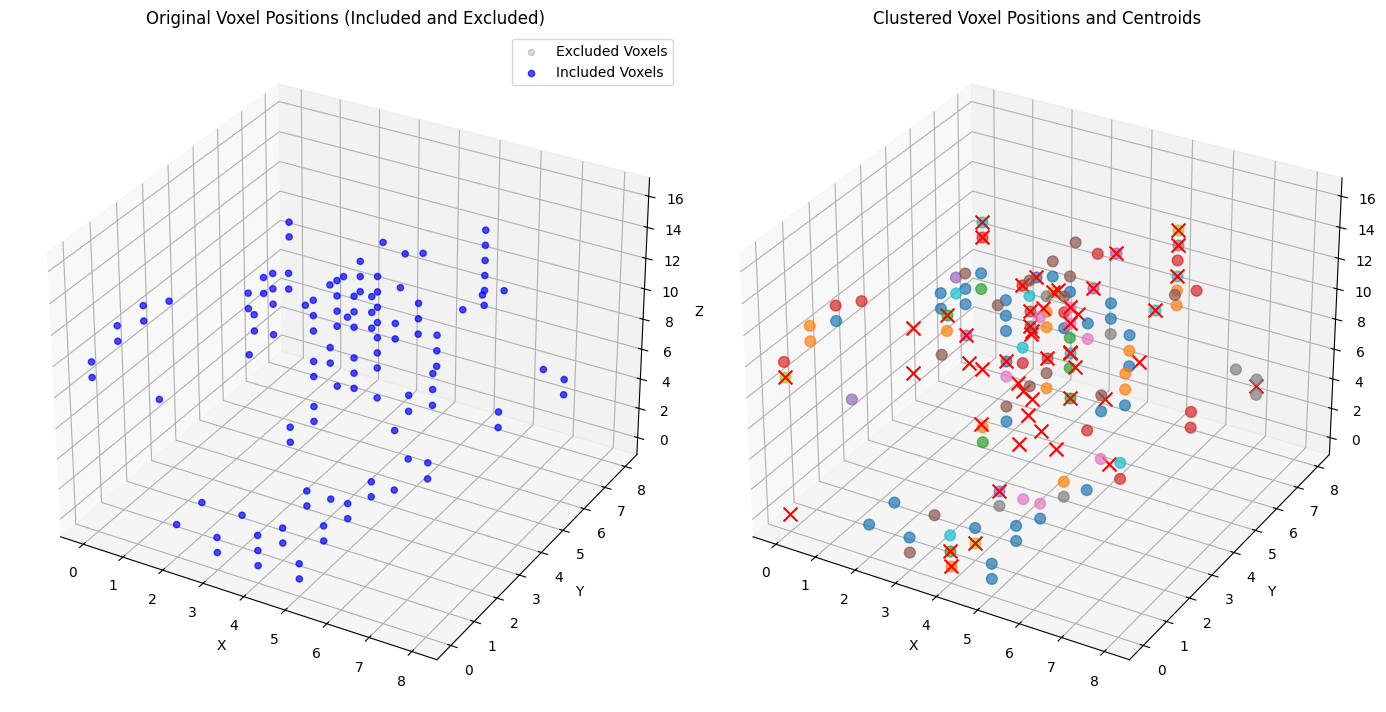

In [124]:
merged_signals, centroids, position_centroids, clustered_signals = cluster_signals(voxel_info, filtered_power, voxel_signals,N_clusters=50, rho_s=0.3, rho_p=0.7, max_iter=1000, tol=1e-4)

In [216]:
def plot_merged_signals(merged_signals, sampling_rate, time_window=4):
    """
    Plot the merged signals along the time axis in a specified time window.
    
    Parameters:
    - merged_signals: Array of merged signals for each cluster (N_clusters, num_time_frames).
    - sampling_rate: Sampling rate of the signals (in Hz).
    - time_window: Time window for plotting (in seconds), default is 2 seconds.
    """
    num_clusters, num_frames = merged_signals.shape
    
    # Calculate the number of frames to display for the given time window
    frames_in_window = int(time_window * sampling_rate)
    
    # Generate the time axis in seconds for the 2-second time frame
    time_axis = np.arange(frames_in_window) / sampling_rate
    
    plt.figure(figsize=(10, 6))
    
    for k in range(50):
        # Plot only the portion of the signal within the 2-second time frame
        # unwrapped_phase = np.unwrap(np.angle(merged_signals[k]))
        # plt.plot(time_axis, unwrapped_phase[:frames_in_window], label=f'Cluster {k} Merged Signal')
        # plt.plot(unwrapped_phase[:frames_in_window], label=f'Cluster {k} Merged Signal')
        plt.plot(merged_signals[k][400:400+frames_in_window], label=f'Cluster {k} Merged Signal')

    average_signal = np.mean(merged_signals[:, 400:400+frames_in_window], axis=0)
    plt.plot(average_signal, label='Average Signal', color='black', linewidth=2.5)
    
    plt.title(f'Signals before Focusing Over {time_window} Seconds')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.ylim(-400, 400)
    #plt.legend()
    plt.show()


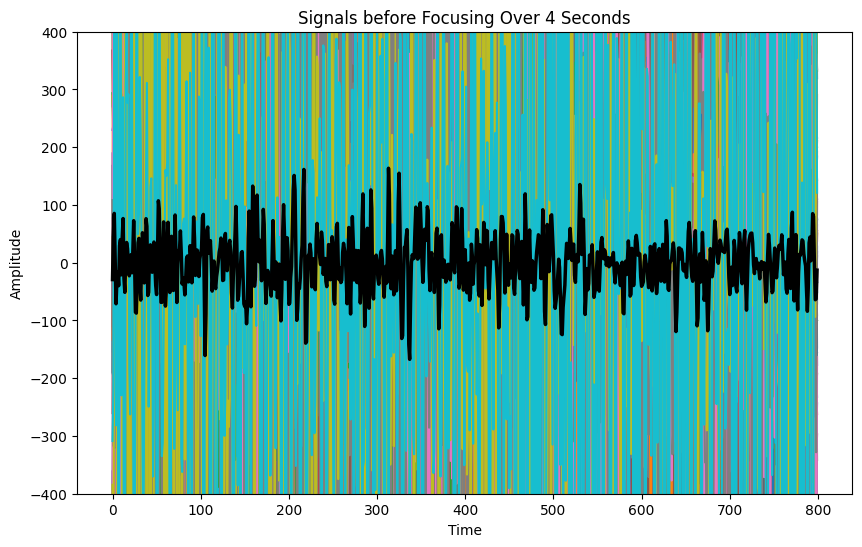

In [217]:
before_focusing = np.array(data[0]).reshape(-1, data[0].shape[-1])  # Reshaping the last axis as the sequence

num_voxels, num_frames = before_focusing.shape
    
# Pre-allocate array for processed signals (assuming processed signals have the same length as original)
processed_signals = np.zeros((num_voxels, num_frames))

dt = 1 / 200  # Time step for second_dev function

for i, signal in enumerate(before_focusing):
    # Step 1: Compute the phase angle of the signal
    phase_angle = np.angle(signal)
    
    # Step 2: Unwrap the phase
    unwrapped_phase = np.unwrap(phase_angle)
    
    # Step 3: Apply the second derivative operation
    processed_signal = micro_motion_amp.second_dev(unwrapped_phase, dt)
    
    # Store the processed signal in the numpy array
    processed_signals[i, :len(processed_signal)] = processed_signal

before_focusing = processed_signals

plot_merged_signals(before_focusing, 200)

In [214]:
def plot_merged_signals2(merged_signals, sampling_rate, time_window=4):
    """
    Plot the merged signals along the time axis in a specified time window.
    
    Parameters:
    - merged_signals: Array of merged signals for each cluster (N_clusters, num_time_frames).
    - sampling_rate: Sampling rate of the signals (in Hz).
    - time_window: Time window for plotting (in seconds), default is 2 seconds.
    """
    num_clusters, num_frames = merged_signals.shape
    
    # Calculate the number of frames to display for the given time window
    frames_in_window = int(time_window * sampling_rate)
    
    # Generate the time axis in seconds for the 2-second time frame
    time_axis = np.arange(frames_in_window) / sampling_rate
    
    plt.figure(figsize=(10, 6))
    
    for k in range(50):
        # Plot only the portion of the signal within the 2-second time frame
        # unwrapped_phase = np.unwrap(np.angle(merged_signals[k]))
        # plt.plot(time_axis, unwrapped_phase[:frames_in_window], label=f'Cluster {k} Merged Signal')
        # plt.plot(unwrapped_phase[:frames_in_window], label=f'Cluster {k} Merged Signal')
        plt.plot(merged_signals[k][400:400+frames_in_window], label=f'Cluster {k} Merged Signal')

    average_signal = np.mean(merged_signals[:, 400:400+frames_in_window], axis=0)
    plt.plot(average_signal, label='Average Signal', color='black', linewidth=2.5)
    
    plt.title(f'Signals after Focusing Over {time_window} Seconds')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.ylim(-400, 400)
    #plt.legend()
    plt.show()

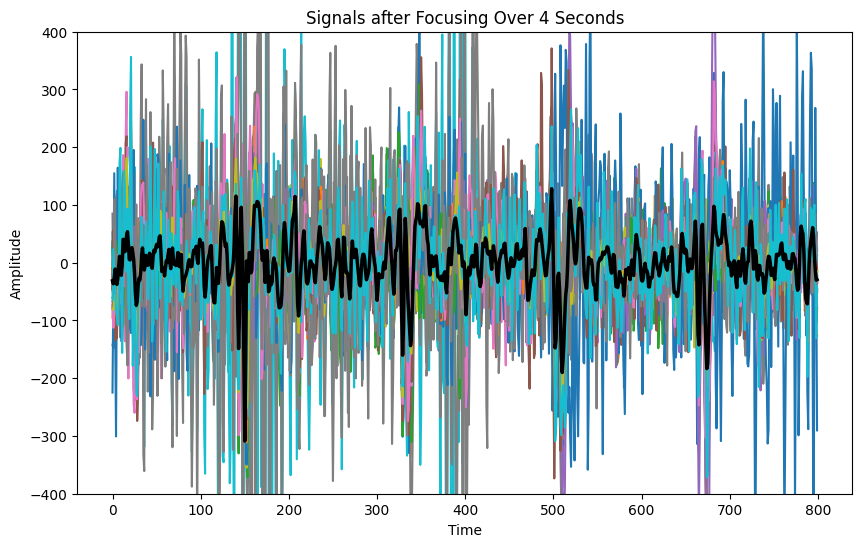

In [215]:
num_voxels, num_frames = voxel_signals.shape
    
# Pre-allocate array for processed signals (assuming processed signals have the same length as original)
processed_signals = np.zeros((num_voxels, num_frames))

dt = 1 / 200  # Time step for second_dev function

for i, signal in enumerate(voxel_signals):
    # Step 1: Compute the phase angle of the signal
    phase_angle = np.angle(signal)
    
    # Step 2: Unwrap the phase
    unwrapped_phase = np.unwrap(phase_angle)
    
    # Step 3: Apply the second derivative operation
    processed_signal = micro_motion_amp.second_dev(unwrapped_phase, dt)
    
    # Store the processed signal in the numpy array
    processed_signals[i, :len(processed_signal)] = processed_signal

voxel_signals_before_cluster = processed_signals

plot_merged_signals2(voxel_signals_before_cluster, 200)

In [206]:
def plot_merged_signals3(merged_signals, sampling_rate, time_window=4):
    """
    Plot the merged signals along the time axis in a specified time window.
    
    Parameters:
    - merged_signals: Array of merged signals for each cluster (N_clusters, num_time_frames).
    - sampling_rate: Sampling rate of the signals (in Hz).
    - time_window: Time window for plotting (in seconds), default is 2 seconds.
    """
    num_clusters, num_frames = merged_signals.shape
    
    # Calculate the number of frames to display for the given time window
    frames_in_window = int(time_window * sampling_rate)
    
    # Generate the time axis in seconds for the 2-second time frame
    time_axis = np.arange(frames_in_window) / sampling_rate
    
    plt.figure(figsize=(10, 6))
    
    for k in range(50):
        # Plot only the portion of the signal within the 2-second time frame
        # unwrapped_phase = np.unwrap(np.angle(merged_signals[k]))
        # plt.plot(time_axis, unwrapped_phase[:frames_in_window], label=f'Cluster {k} Merged Signal')
        # plt.plot(unwrapped_phase[:frames_in_window], label=f'Cluster {k} Merged Signal')
        plt.plot(merged_signals[k][400:400+frames_in_window], label=f'Cluster {k} Merged Signal')

    average_signal = np.mean(merged_signals[:, 400:400+frames_in_window], axis=0)
    plt.plot(average_signal, label='Average Signal', color='black', linewidth=2.5)
    
    plt.title(f'Signals after Clustering Over {time_window} Seconds')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.ylim(-400, 400)
    #plt.legend()
    plt.show()

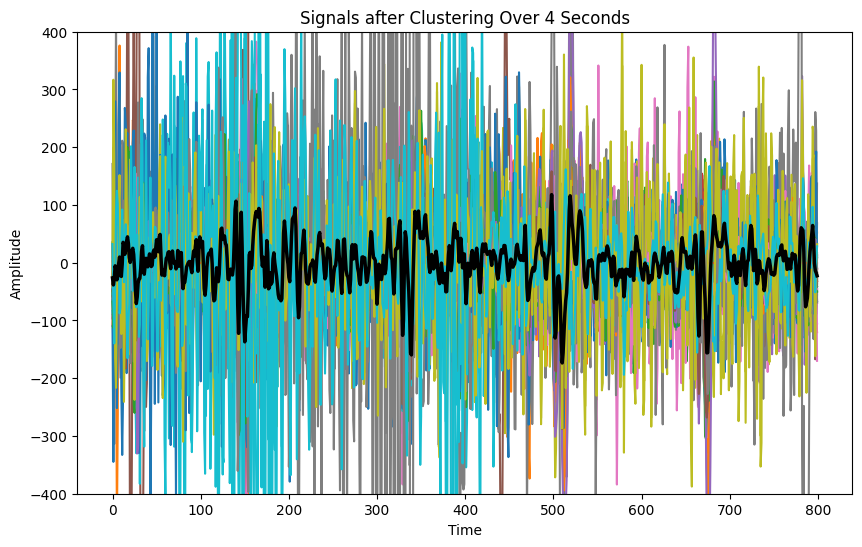

In [207]:
plot_merged_signals3(merged_signals, 200)

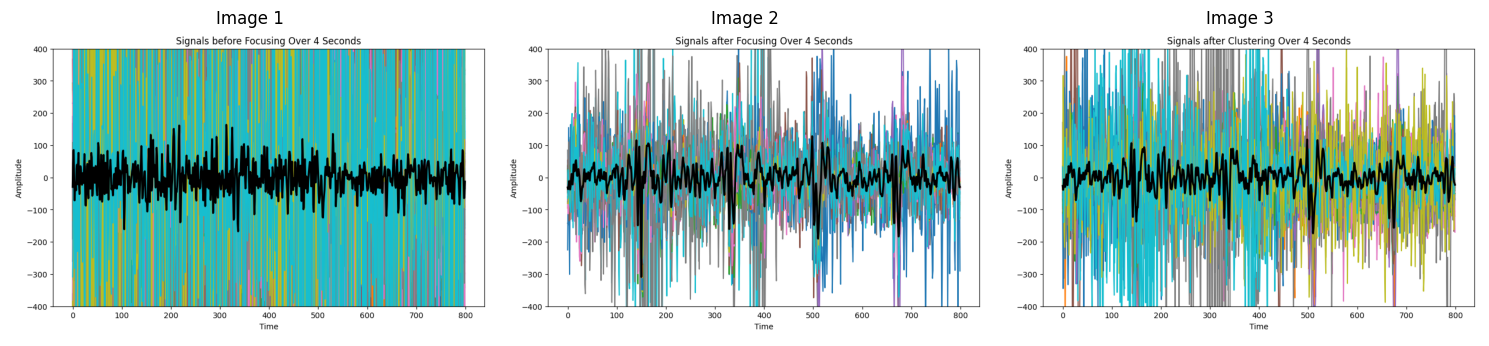

In [248]:
import matplotlib.image as mpimg

# Load the images using raw strings or forward slashes
image1 = mpimg.imread(r'plots/signal_before_focusing_over4s.png')
image2 = mpimg.imread(r'plots/signal_after_focusing_over4s.png')
image3 = mpimg.imread(r'plots/signal_after_cluster_over4s.png')

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display the images in the subplots
axs[0].imshow(image1)
axs[0].axis('off')  # Hide axes
axs[0].set_title("Image 1")

axs[1].imshow(image2)
axs[1].axis('off')
axs[1].set_title("Image 2")

axs[2].imshow(image3)
axs[2].axis('off')
axs[2].set_title("Image 3")

# Show the plot
plt.tight_layout()
plt.show()